# Objective
* 20190102: 
    * Predict stock price in next day using long short term memory(LSTM)
    * Given prices for the last N days, we do prediction for day N+1
    * Here we split 3 years of data into train(60%), dev(20%) and test(20%)

In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import time

from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

%matplotlib inline

#### Input params ##################
stk_path = "./data/VTI.csv"
test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set
N = 30                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

model_seed = 100

fontsize = 14
ticklabelsize = 14
####################################

/Users/yibin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load data

In [3]:
df = pd.read_csv(stk_path, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head()

,date,open,high,low,close,adj_close,volume,month
0,2015-11-25,107.510002,107.660004,107.250000,107.470001,101.497200,1820300,11
1,2015-11-27,107.589996,107.760002,107.220001,107.629997,101.648300,552400,11
2,2015-11-30,107.779999,107.849998,107.110001,107.169998,101.213867,3618100,11
3,2015-12-01,107.589996,108.209999,107.370003,108.180000,102.167740,2443600,12
4,2015-12-02,108.099998,108.269997,106.879997,107.050003,101.100533,2937200,12


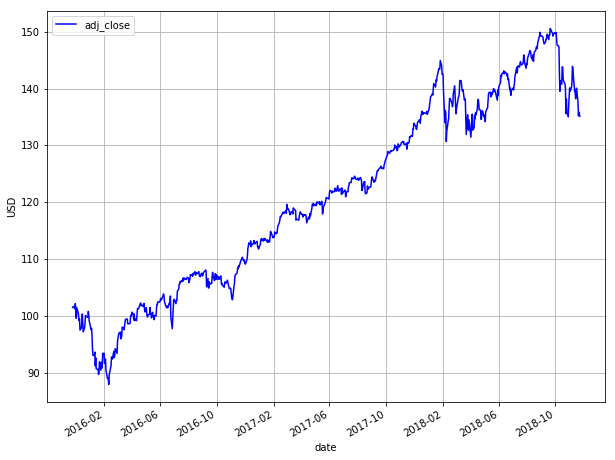

In [4]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Split into train, dev and test sets

We use lags up to N number of days to use as features.

In [5]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train][['date', 'adj_close']]
cv = df[num_train:num_train+num_cv][['date', 'adj_close']]
train_cv = df[:num_train+num_cv][['date', 'adj_close']]
test = df[num_train+num_cv:][['date', 'adj_close']]

print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 453
num_cv = 151
num_test = 151
train.shape = (453, 2)
cv.shape = (151, 2)
train_cv.shape = (604, 2)
test.shape = (151, 2)


In [6]:
# Converting dataset into x_train and y_train
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(np.array(train['adj_close']).reshape(-1,1))
print("scaler.data_min_ = " + str(scaler.data_min_))
print("scaler.data_max_ = " + str(scaler.data_max_))

x_train, y_train = [], []
for i in range(N,len(train)):
    x_train.append(train_scaled[i-N:i])
    y_train.append(train_scaled[i])
x_train = np.array(x_train)
y_train = np.array(y_train)

print("x_train.shape = " + str(x_train.shape)) # (446, 7, 1)
print("y_train.shape = " + str(y_train.shape)) # (446, 1)

# x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)) # (446, 7, 1)
# print("x_train.shape = " + str(x_train.shape))

scaler.data_min_ = [87.91394]
scaler.data_max_ = [125.576111]
x_train.shape = (423, 30, 1)
y_train.shape = (423, 1)


# Create and fit the LSTM network

In [7]:
# Create the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

Epoch 1/1
 - 23s - loss: 0.0071


# Predict on dev set

In [8]:
# Scale the cv dataset according the min and max obtained from train set
train_cv_scaled  = scaler.transform(np.array(train_cv['adj_close']).reshape(-1,1))

x_cv, y_cv = [], []
for i in range(len(train),len(train_cv_scaled)):
    x_cv.append(train_cv_scaled[i-N:i])
    y_cv.append(train_cv_scaled[i])
x_cv = np.array(x_cv)
y_cv = np.array(y_cv)

print("x_cv.shape = " + str(x_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))

x_cv.shape = (151, 30, 1)
y_cv.shape = (151, 1)


In [10]:
# Do prediction
est = model.predict(x_cv)
est_inv = scaler.inverse_transform(est)

# Get correct scale of y_cv
y_cv_inv = scaler.inverse_transform(y_cv)

# Calculate RMSE
print("RMSE = " + str(math.sqrt(mean_squared_error(y_cv_inv, est_inv))))

RMSE = 2.2606841958857746


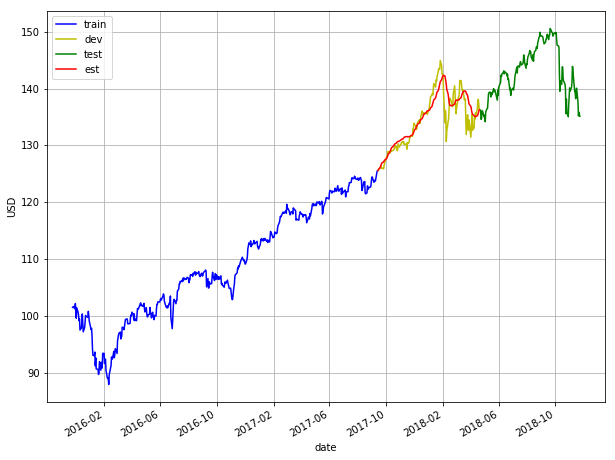

In [11]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est_inv': est_inv.reshape(-1), 
                       'y_cv_inv': y_cv_inv.reshape(-1),
                       'date': df[num_train:num_train+num_cv]['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est_inv', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'est'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Findings
* The lowest RMSE is obtained using ...